In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mplsoccer import Pitch, VerticalPitch  
from pathlib import Path
import os
import json
import csv
from tqdm import tqdm
import logging
from dotenv import load_dotenv
from pathlib import Path
import os
from json import JSONDecodeError

load_dotenv()

DATA_ROOT = Path(os.environ["EXJOBB_DATA"])
sb_root = DATA_ROOT / "open-data-master" / "data"
matches_dir = sb_root / "matches"
events_dir  = sb_root / "events"
three_dir   = sb_root / "three-sixty"

assert three_dir.exists(), f"Missing: {three_dir}"


In [135]:
three_files = sorted(three_dir.glob("*.json"))
three_match_ids = sorted(int(p.stem) for p in three_files)

comps = pd.read_json(sb_root / "competitions.json")

rows = []
for mf in sorted(matches_dir.rglob("*.json")):
    comp_id = int(mf.parent.name)
    season_id = int(mf.stem)
    data = json.loads(mf.read_text())
    for m in data:
        if m["match_id"] in set(three_match_ids):
            rows.append({
                "competition_id": comp_id,
                "season_id": season_id,
                "match_id": m["match_id"],
                "match_date": m.get("match_date"),
                "home_team": m["home_team"]["home_team_name"],
                "away_team": m["away_team"]["away_team_name"],
                "home_team_id": m["home_team"]["home_team_id"],
                "away_team_id": m["away_team"]["away_team_id"],
            })

matches_360 = pd.DataFrame(rows).merge(
    comps[["competition_id","season_id","competition_name","season_name"]],
    on=["competition_id","season_id"],
    how="left",
)


match_meta = (
    matches_360[["match_id", "home_team_id", "away_team_id"]]
    .drop_duplicates("match_id")
    .set_index("match_id")
    .to_dict("index")
)

In [136]:
def load_json(path: Path):
    try:
        return json.loads(path.read_text())
    except JSONDecodeError as e:
        print(f"[BAD JSON] {path.name}  line {e.lineno} col {e.colno}  pos {e.pos}")
        return None

def visible_area_area(vis):
    # polygon area of visible_area (flat [x1,y1,...] or nested [[x,y],...])
    if vis is None:
        return np.nan
    arr = np.asarray(vis, dtype=float)
    if arr.ndim == 1:
        if arr.size < 6 or arr.size % 2: 
            return np.nan
        pts = arr.reshape(-1,2)
    elif arr.ndim == 2 and arr.shape[1] == 2 and arr.shape[0] >= 3:
        pts = arr
    else:
        return np.nan
    x, y = pts[:,0], pts[:,1]
    return 0.5 * np.abs(np.dot(x, np.roll(y,-1)) - np.dot(y, np.roll(x,-1)))

def extract_freeze_points(rec, flip=False):
    ff = rec.get("freeze_frame", [])
    if not isinstance(ff, list) or len(ff) == 0:
        return None

    xs, ys, teammate, actor, keeper = [], [], [], [], []
    for p in ff:
        loc = p.get("location")
        if not loc:
            continue
        x, y = loc
        if flip:
            x, y = mirror_xy(x, y)

        xs.append(x); ys.append(y)
        teammate.append(bool(p.get("teammate", False)))
        actor.append(bool(p.get("actor", False)))
        keeper.append(bool(p.get("keeper", False)))

    if len(xs) == 0:
        return None

    return {
        "x": np.array(xs, dtype=float),
        "y": np.array(ys, dtype=float),
        "teammate": np.array(teammate, dtype=bool),
        "actor": np.array(actor, dtype=bool),
        "keeper": np.array(keeper, dtype=bool),
    }


def mirror_xy(x, y):
    return 120.0 - x, 80.0 - y


In [137]:

def lane_obstruction_features(x0, y0, x1, y1, opp_x, opp_y, lane_width=1.5):
    vx, vy = (x1 - x0), (y1 - y0)
    L2 = vx*vx + vy*vy
    if L2 < 1e-6 or len(opp_x) == 0:
        return {
            "min_opp_dist_to_lane": np.nan,
            f"n_opp_in_lane_{lane_width}": 0,
            f"lane_blocked_{lane_width}": 0,
        }

    wx = opp_x - x0
    wy = opp_y - y0

    t = (wx*vx + wy*vy) / L2
    between = (t >= 0.0) & (t <= 1.0)

    if not between.any():
        return {
            "min_opp_dist_to_lane": np.nan,
            f"n_opp_in_lane_{lane_width}": 0,
            f"lane_blocked_{lane_width}": 0,
        }

    t = np.clip(t, 0.0, 1.0)
    proj_x = x0 + t * vx
    proj_y = y0 + t * vy

    dist = np.sqrt((opp_x - proj_x)**2 + (opp_y - proj_y)**2)
    dist_between = dist[between]

    min_dist = float(dist_between.min())

    return {
        "min_opp_dist_to_lane": min_dist,
        f"n_opp_in_lane_{lane_width}": int((dist_between <= lane_width).sum()),
        f"lane_blocked_{lane_width}": int(min_dist <= lane_width),
    }


def compute_pass_features(ev, rec, R=17.0, lane_width=2.5, flip=False):

    # freeze frame points (already flipped if needed)
    pts = extract_freeze_points(rec, flip=flip)
    if pts is None:
        return None

    # start location
    ev_loc = ev.get("location")
    if ev_loc is None:
        a_mask = pts["actor"]
        if not a_mask.any():
            return None
        x0, y0 = float(pts["x"][a_mask][0]), float(pts["y"][a_mask][0])
    else:
        x0, y0 = map(float, ev_loc)
        if flip:
            x0, y0 = mirror_xy(x0, y0)

    # end location
    p = ev.get("pass")
    if not isinstance(p, dict) or p.get("end_location") is None:
        return None
    x1, y1 = map(float, p["end_location"])
    if flip:
        x1, y1 = mirror_xy(x1, y1)

    # teammates/opponents
    tm = pts["teammate"].copy()
    op = ~tm
    tm = tm & ~pts["actor"]  # exclude actor from teammate pool

    opp_x = pts["x"][op]
    opp_y = pts["y"][op]

    # distances to passer
    dx = pts["x"] - x0
    dy = pts["y"] - y0
    d = np.sqrt(dx*dx + dy*dy)

    d_tm = d[tm] if tm.any() else np.array([])
    d_op = d[op] if op.any() else np.array([])

    feat = {
        "x_start": x0, "y_start": y0,
        "x_end": x1, "y_end": y1,  # labels

        "n_players_visible": len(pts["x"]),
        "n_teammates_visible": int(tm.sum()),
        "n_opponents_visible": int(op.sum()),

        "nearest_teammate_dist": float(d_tm.min()) if d_tm.size else np.nan,
        "nearest_opponent_dist": float(d_op.min()) if d_op.size else np.nan,

        f"teammates_within_{R}": int((d_tm <= R).sum()) if d_tm.size else 0,
        f"opponents_within_{R}": int((d_op <= R).sum()) if d_op.size else 0,

        "teammate_dist_mean": float(d_tm.mean()) if d_tm.size else np.nan,
        "opponent_dist_mean": float(d_op.mean()) if d_op.size else np.nan,

        "visible_area": float(visible_area_area(rec.get("visible_area"))),

        # helpful later
        "flip_lr": int(flip),
    }

    # lane obstruction features (uses flipped coords too)
    lane_feats = lane_obstruction_features(x0, y0, x1, y1, opp_x, opp_y, lane_width=lane_width)
    feat.update(lane_feats)

    # spread
    feat["tm_x_std"] = float(np.std(pts["x"][tm])) if tm.any() else np.nan
    feat["tm_y_std"] = float(np.std(pts["y"][tm])) if tm.any() else np.nan
    feat["op_x_std"] = float(np.std(pts["x"][op])) if op.any() else np.nan
    feat["op_y_std"] = float(np.std(pts["y"][op])) if op.any() else np.nan

    # metadata
    feat["event_id"] = ev.get("id")
    feat["minute"] = ev.get("minute")
    feat["second"] = ev.get("second")
    feat["team_id"] = ev.get("team", {}).get("id") if isinstance(ev.get("team"), dict) else None
    feat["player_id"] = ev.get("player", {}).get("id") if isinstance(ev.get("player"), dict) else None

    return feat


def add_angle_features(ev, rec, feat: dict, k_teammates: int = 3, flip: bool = False):
    """
    Adds angle-relevant features to an existing feat dict (output from compute_pass_features).
    Does not modify compute_pass_features or lane_obstruction_features.

    Requires: extract_freeze_points(rec, flip=...), mirror_xy(x,y)
    Assumes StatsBomb pitch 120x80.

    Returns: updated dict (also modifies feat in-place).
    """
    pts = extract_freeze_points(rec, flip=flip)
    if pts is None:
        return feat

    # start location (prefer feat, otherwise from event/actor)
    x0 = feat.get("x_start", None)
    y0 = feat.get("y_start", None)
    if x0 is None or y0 is None:
        ev_loc = ev.get("location")
        if ev_loc is not None:
            x0, y0 = map(float, ev_loc)
            if flip:
                x0, y0 = mirror_xy(x0, y0)
        else:
            a_mask = pts["actor"]
            if not a_mask.any():
                return feat
            x0 = float(pts["x"][a_mask][0])
            y0 = float(pts["y"][a_mask][0])

    # --- Goal-relative geometry (attacking right goal at x=120, y=40 after optional flip) ---
    goal_x, goal_y = 120.0, 40.0
    dxg, dyg = goal_x - x0, goal_y - y0
    dist_goal = float(np.hypot(dxg, dyg))
    angle_goal = float(np.arctan2(dyg, dxg))  # radians

    feat.update({
        "dist_to_goal": dist_goal,
        "angle_to_goal": angle_goal,
        "sin_angle_to_goal": float(np.sin(angle_goal)),
        "cos_angle_to_goal": float(np.cos(angle_goal)),
        "x_progress_to_goal": float(dxg),  # basically 120-x0
        "abs_y_from_goal_center": float(abs(y0 - goal_y)),
    })

    # --- Teammate / opponent masks ---
    tm_mask = pts["teammate"].copy()
    op_mask = ~tm_mask
    tm_mask = tm_mask & ~pts["actor"]  # exclude actor from teammates

    tm_x = pts["x"][tm_mask]
    tm_y = pts["y"][tm_mask]
    op_x = pts["x"][op_mask]
    op_y = pts["y"][op_mask]

    # If no teammates visible, nothing else to add
    if tm_x.size == 0:
        # still add something simple
        feat.update({
            "n_teammates_ahead_x": 0,
            "n_teammates_behind_x": 0,
        })
        return feat

    # --- Relative vectors to teammates (top-k nearest) ---
    tm_dx = tm_x - x0
    tm_dy = tm_y - y0
    tm_dist = np.hypot(tm_dx, tm_dy)
    tm_angle = np.arctan2(tm_dy, tm_dx)

    order = np.argsort(tm_dist)
    k = min(k_teammates, len(order))

    for i in range(k):
        j = order[i]
        feat[f"tm{i+1}_dx"] = float(tm_dx[j])
        feat[f"tm{i+1}_dy"] = float(tm_dy[j])
        feat[f"tm{i+1}_dist"] = float(tm_dist[j])
        feat[f"tm{i+1}_angle"] = float(tm_angle[j])
        feat[f"tm{i+1}_sin_angle"] = float(np.sin(tm_angle[j]))
        feat[f"tm{i+1}_cos_angle"] = float(np.cos(tm_angle[j]))

        # how "goalward" is this teammate relative to passer?
        feat[f"tm{i+1}_goal_progress"] = float(goal_x - tm_x[j])  # smaller is closer to goal
        feat[f"tm{i+1}_dist_to_goal"] = float(np.hypot(goal_x - tm_x[j], goal_y - tm_y[j]))

    # --- Simple ahead/behind counts to break symmetry ---
    feat["n_teammates_ahead_x"] = int((tm_x > x0).sum())
    feat["n_teammates_behind_x"] = int((tm_x < x0).sum())
    feat["frac_teammates_ahead_x"] = float((tm_x > x0).mean())

    # --- Teammate openness: nearest opponent distance to each teammate ---
    # (vectorized; O(N_tm * N_op) but N is small in 360)
    if op_x.size > 0:
        # distances between every teammate and every opponent
        dx_mat = tm_x[:, None] - op_x[None, :]
        dy_mat = tm_y[:, None] - op_y[None, :]
        tm_nearest_op_dist = np.sqrt(dx_mat * dx_mat + dy_mat * dy_mat).min(axis=1)

        feat["tm_open_mean"] = float(np.mean(tm_nearest_op_dist))
        feat["tm_open_min"] = float(np.min(tm_nearest_op_dist))
        feat["tm_open_max"] = float(np.max(tm_nearest_op_dist))
        feat["n_open_teammates_gt_3"] = int((tm_nearest_op_dist > 3.0).sum())
        feat["n_open_teammates_gt_5"] = int((tm_nearest_op_dist > 5.0).sum())

        # Attach openness for the k nearest teammates
        for i in range(k):
            j = order[i]
            feat[f"tm{i+1}_open"] = float(tm_nearest_op_dist[j])
    else:
        # no opponents visible -> treat as very open (but keep bounded)
        feat["tm_open_mean"] = np.nan
        feat["tm_open_min"] = np.nan
        feat["tm_open_max"] = np.nan
        feat["n_open_teammates_gt_3"] = 0
        feat["n_open_teammates_gt_5"] = 0
        for i in range(k):
            feat[f"tm{i+1}_open"] = np.nan

    # --- “Best option” summary: best teammate by a simple score ---
    # score = openness (prefer higher) + progress (prefer closer to goal -> smaller dist_to_goal)
    if op_x.size > 0:
        # normalize a bit to avoid scale dominance
        prog = np.hypot(goal_x - tm_x, goal_y - tm_y)  # dist_to_goal for teammate
        open_ = tm_nearest_op_dist
        # higher score = better: open + (progressive)
        score = open_ + 0.2 * (dist_goal - prog)  # positive if teammate is closer to goal than passer
        best = int(np.argmax(score))

        feat["best_tm_open"] = float(open_[best])
        feat["best_tm_dist"] = float(tm_dist[best])
        feat["best_tm_angle"] = float(tm_angle[best])
        feat["best_tm_sin_angle"] = float(np.sin(tm_angle[best]))
        feat["best_tm_cos_angle"] = float(np.cos(tm_angle[best]))
        feat["best_tm_dist_to_goal"] = float(prog[best])
        feat["best_tm_progress_gain"] = float(dist_goal - prog[best])
    else:
        feat["best_tm_open"] = np.nan
        feat["best_tm_dist"] = float(np.min(tm_dist))
        best = int(np.argmin(tm_dist))
        feat["best_tm_angle"] = float(tm_angle[best])
        feat["best_tm_sin_angle"] = float(np.sin(tm_angle[best]))
        feat["best_tm_cos_angle"] = float(np.cos(tm_angle[best]))
        feat["best_tm_dist_to_goal"] = float(np.hypot(goal_x - tm_x[best], goal_y - tm_y[best]))
        feat["best_tm_progress_gain"] = float(dist_goal - feat["best_tm_dist_to_goal"])

    return feat


In [138]:
def build_pass_dataset(sb_root, match_ids, match_meta, limit_matches=None, R=17.0, lane_width=2.5):
    out = []
    match_ids = match_ids[:limit_matches] if limit_matches else match_ids

    for i, mid in enumerate(match_ids, 1):
        events_path = sb_root / "events" / f"{mid}.json"
        three_path  = sb_root / "three-sixty" / f"{mid}.json"
        if not events_path.exists() or not three_path.exists():
            continue


        events = load_json(events_path)
        three  = load_json(three_path)
        if three is None:
            continue

        rec_by_uuid = {r["event_uuid"]: r for r in three if "event_uuid" in r}

        for ev in events:
            if ev.get("type", {}).get("name") != "Pass":
                continue
            
            uuid = ev.get("id")
            if uuid not in rec_by_uuid:
                continue

            feat = compute_pass_features(
                ev,
                rec_by_uuid[uuid],
                R=R,
                lane_width=lane_width,
                
            )
            if feat is None:
                continue
            add_angle_features(ev, rec_by_uuid[uuid], feat, k_teammates=3)
            feat["match_id"] = mid
            out.append(feat)

        if i % 25 == 0:
            print(f"processed {i}/{len(match_ids)} matches, rows={len(out)}")

    return pd.DataFrame(out)


df = build_pass_dataset(sb_root, three_match_ids,match_meta, limit_matches=None)  # start small
df.head(), df.shape


processed 25/326 matches, rows=21550
processed 50/326 matches, rows=45024
[BAD JSON] 3835338.json  line 181321 col 20  pos 5193728
[BAD JSON] 3835342.json  line 171856 col 109  pos 4882432
[BAD JSON] 3845506.json  line 92794 col 3  pos 2637824
processed 100/326 matches, rows=84951
processed 125/326 matches, rows=107518
processed 150/326 matches, rows=129912
processed 175/326 matches, rows=149772
processed 200/326 matches, rows=170834
processed 225/326 matches, rows=195266
processed 250/326 matches, rows=217194
processed 275/326 matches, rows=239018
processed 300/326 matches, rows=261378
processed 325/326 matches, rows=280742


(   x_start  y_start  x_end  y_end  n_players_visible  n_teammates_visible  \
 0     60.0     40.0   32.5   28.8                 10                    3   
 1     36.2     30.4   70.7   75.8                 18                    9   
 2     43.1      0.1   15.8    7.5                 15                    7   
 3      3.3     12.7    7.9   36.2                  6                    4   
 4      9.1     38.9   19.7   47.9                 10                    6   
 
    n_opponents_visible  nearest_teammate_dist  nearest_opponent_dist  \
 0                    6               8.442516               8.700299   
 1                    8              11.121507               5.362913   
 2                    7              13.713861               9.050701   
 3                    1              18.359373              34.110872   
 4                    3              11.379301              29.491182   
 
    teammates_within_17.0  ...   tm2_open   tm3_open  best_tm_open  \
 0                  

In [139]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

def mean_l2_error(xp, yp, xt, yt):
    return float(np.mean(np.sqrt((xp-xt)**2 + (yp-yt)**2)))

# 1) split first (group by match)
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df["match_id"]))
train = df.iloc[train_idx].copy()
test  = df.iloc[test_idx].copy()

# 2) baseline A
err_A = mean_l2_error(test["x_start"], test["y_start"], test["x_end"], test["y_end"])
print("Baseline A (end=start) mean error:", err_A)

# 3) baseline B (mean delta, correctly computed from TRAIN)
dx_mean = (train["x_end"] - train["x_start"]).mean()
dy_mean = (train["y_end"] - train["y_start"]).mean()

x_pred = test["x_start"] + dx_mean
y_pred = test["y_start"] + dy_mean

err_B = mean_l2_error(x_pred, y_pred, test["x_end"], test["y_end"])
print("Baseline B (mean delta) mean error:", err_B)

# 4) polar targets per ROW (not means)
for d in (train, test):
    dx = d["x_end"] - d["x_start"]
    dy = d["y_end"] - d["y_start"]
    d["pass_len"] = np.hypot(dx, dy)
    d["pass_angle"] = np.arctan2(dy, dx)
    d["angle_sin"] = np.sin(d["pass_angle"])
    d["angle_cos"] = np.cos(d["pass_angle"])
    d["pass_len_log"] = np.log1p(d["pass_len"])

err_B = mean_l2_error(x_pred, y_pred, test["x_end"], test["y_end"])
print("Baseline B (mean delta) mean error:", err_B)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor

X_cols_event_only = ["x_start", "y_start", "minute", "second"]
y_cols = ["angle_sin", "angle_cos", "pass_len_log"]


X_train = train[X_cols_event_only]
X_test  = test[X_cols_event_only]
y_train = train[y_cols]
y_test  = test[y_cols]

model_event = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("reg", MultiOutputRegressor(Ridge(alpha=1.0)))
])

model_event.fit(X_train, y_train)
pred = model_event.predict(X_test)

sin_p = pred[:, 0]
cos_p = pred[:, 1]
len_p = np.expm1(pred[:, 2])

# True values
sin_t = y_test["angle_sin"].to_numpy()
cos_t = y_test["angle_cos"].to_numpy()
len_t = np.expm1(y_test["pass_len_log"].to_numpy())

theta_p = np.arctan2(sin_p, cos_p)
theta_t = np.arctan2(sin_t, cos_t)

# wrapped angular error (radians -> degrees)
ang_err = np.abs(np.arctan2(np.sin(theta_p - theta_t), np.cos(theta_p - theta_t)))
ang_err_deg = np.degrees(ang_err)

len_err = np.abs(len_p - len_t)
print("Median angle err (deg):", float(np.median(ang_err_deg)))
print("Mean angle err (deg):", float(np.mean(ang_err_deg)))
print("Median length err (m):", float(np.median(len_err)))
print("Mean length err (m):", float(np.mean(len_err)))


Baseline A (end=start) mean error: 19.815057009382812
Baseline B (mean delta) mean error: 19.396507444011707
Baseline B (mean delta) mean error: 19.396507444011707
Median angle err (deg): 61.8606730518172
Mean angle err (deg): 66.79148546150711
Median length err (m): 6.249701049994799
Mean length err (m): 8.85547351369593


In [146]:
#Ridge Baseline

X_cols_360 = [
    "x_start","y_start","minute","second",
    "nearest_opponent_dist","nearest_teammate_dist",
    "opponents_within_17.0","teammates_within_17.0",
    "opponent_dist_mean","teammate_dist_mean",
    "op_x_std","op_y_std","tm_x_std","tm_y_std",
    "visible_area",
    "n_opponents_visible","n_teammates_visible","n_players_visible",
    "min_opp_dist_to_lane",
    "n_opp_in_lane_2.5",
    "lane_blocked_2.5",
    "dist_to_goal",
    "sin_angle_to_goal",
    "cos_angle_to_goal",
    "x_progress_to_goal",
    "abs_y_from_goal_center",
    "best_tm_open",
    "best_tm_dist",
    "best_tm_sin_angle",
    "best_tm_cos_angle",
    "best_tm_dist_to_goal",
    "best_tm_progress_gain",
]

X_train = train[X_cols_360]
X_test  = test[X_cols_360]

model_360 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("reg", MultiOutputRegressor(Ridge(alpha=1.0)))
])

model_360.fit(X_train, y_train)
pred = model_360.predict(X_test)
sin_p = pred[:, 0]
cos_p = pred[:, 1]
len_p = np.expm1(pred[:, 2])

# True values
sin_t = y_test["angle_sin"].to_numpy()
cos_t = y_test["angle_cos"].to_numpy()
len_t = np.expm1(y_test["pass_len_log"].to_numpy())

theta_p = np.arctan2(sin_p, cos_p)
theta_t = np.arctan2(sin_t, cos_t)

# wrapped angular error (radians -> degrees)
ang_err = np.abs(np.arctan2(np.sin(theta_p - theta_t), np.cos(theta_p - theta_t)))
ang_err_deg = np.degrees(ang_err)

len_err = np.abs(len_p - len_t)
print("Median angle err (deg):", float(np.median(ang_err_deg)))
print("Mean angle err (deg):", float(np.mean(ang_err_deg)))
print("Median length err (m):", float(np.median(len_err)))
print("Mean length err (m):", float(np.mean(len_err)))


Median angle err (deg): 43.94168735920167
Mean angle err (deg): 56.80666733675996
Median length err (m): 5.4384629790218675
Mean length err (m): 7.828580285161084


In [147]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np

model_hgb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("reg", MultiOutputRegressor(
        HistGradientBoostingRegressor(
            max_depth=6,
            learning_rate=0.05,
            max_iter=400,
            random_state=42
        )
    ))
])

model_hgb.fit(train[X_cols_360], train[y_cols])
pred = model_hgb.predict(test[X_cols_360])

sin_p = pred[:, 0]
cos_p = pred[:, 1]
len_p = np.expm1(pred[:, 2])

# True values
sin_t = y_test["angle_sin"].to_numpy()
cos_t = y_test["angle_cos"].to_numpy()
len_t = np.expm1(y_test["pass_len_log"].to_numpy())

theta_p = np.arctan2(sin_p, cos_p)
theta_t = np.arctan2(sin_t, cos_t)

x0 = test["x_start"].to_numpy()
y0 = test["y_start"].to_numpy()

x_pred = x0 + len_p * np.cos(theta_p)
y_pred = y0 + len_p * np.sin(theta_p)

test_vis = test.copy()
test_vis["x_pred"] = x_pred
test_vis["y_pred"] = y_pred


# wrapped angular error (radians -> degrees)
ang_err = np.abs(np.arctan2(np.sin(theta_p - theta_t), np.cos(theta_p - theta_t)))
ang_err_deg = np.degrees(ang_err)

len_err = np.abs(len_p - len_t)
x_true = test["x_end"].to_numpy()
y_true = test["y_end"].to_numpy()

end_err = np.sqrt((x_pred - x_true)**2 + (y_pred - y_true)**2)

print("Median endpoint error (m):", float(np.median(end_err)))
print("Mean endpoint error (m):", float(np.mean(end_err)))
print("Median angle err (deg):", float(np.median(ang_err_deg)))
print("Mean angle err (deg):", float(np.mean(ang_err_deg)))
print("Median length err (m):", float(np.median(len_err)))
print("Mean length err (m):", float(np.mean(len_err)))


Median endpoint error (m): 13.611621815308093
Mean endpoint error (m): 16.12729878303355
Median angle err (deg): 37.296306101020825
Mean angle err (deg): 49.99193073424391
Median length err (m): 4.825016909709152
Mean length err (m): 6.960281129510864


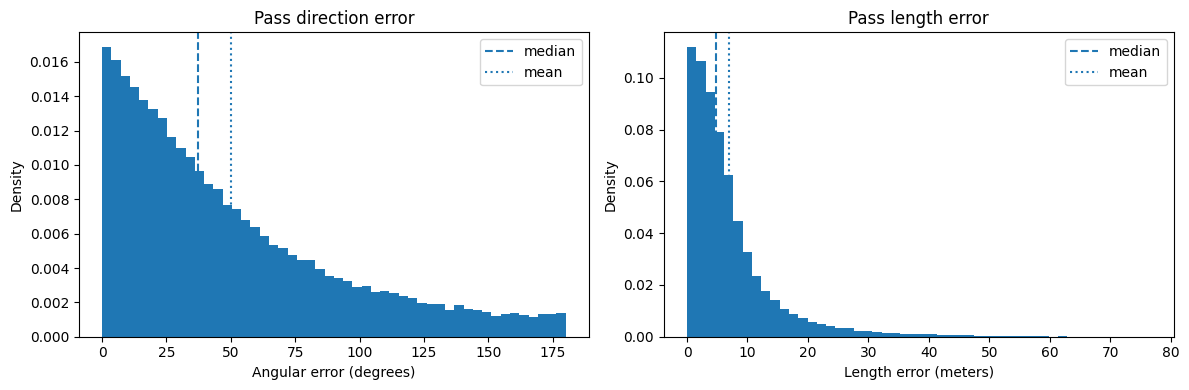

In [148]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Angle error histogram
axs[0].hist(ang_err_deg, bins=50, density=True)
axs[0].axvline(np.median(ang_err_deg), linestyle="--", label="median")
axs[0].axvline(np.mean(ang_err_deg), linestyle=":", label="mean")
axs[0].set_xlabel("Angular error (degrees)")
axs[0].set_ylabel("Density")
axs[0].set_title("Pass direction error")
axs[0].legend()

# Length error histogram
axs[1].hist(len_err, bins=50, density=True)
axs[1].axvline(np.median(len_err), linestyle="--", label="median")
axs[1].axvline(np.mean(len_err), linestyle=":", label="mean")
axs[1].set_xlabel("Length error (meters)")
axs[1].set_ylabel("Density")
axs[1].set_title("Pass length error")
axs[1].legend()

plt.tight_layout()
plt.show()


In [149]:

_three_cache = {}
_events_cache = {}

def _load_three_for_match(sb_root, match_id):
    if match_id not in _three_cache:
        path = sb_root / "three-sixty" / f"{match_id}.json"
        three = json.loads(path.read_text())
        _three_cache[match_id] = {r["event_uuid"]: r for r in three if "event_uuid" in r}
    return _three_cache[match_id]

def _load_events_for_match(sb_root, match_id):
    if match_id not in _events_cache:
        path = sb_root / "events" / f"{match_id}.json"
        events = json.loads(path.read_text())
        _events_cache[match_id] = {e["id"]: e for e in events if "id" in e}
    return _events_cache[match_id]

def _visible_area_xy(vis):
    if vis is None:
        return None
    arr = np.asarray(vis, dtype=float)
    if arr.ndim == 1:
        if arr.size >= 6 and arr.size % 2 == 0:
            return arr.reshape(-1, 2)
        return None
    if arr.ndim == 2 and arr.shape[1] == 2 and arr.shape[0] >= 3:
        return arr
    return None

def plot_pass_with_freeze_frame(sb_root, row, show_visible_area=True, figsize=(9, 6)):
    match_id = int(row["match_id"])
    event_id = row["event_id"]

    rec_by_uuid = _load_three_for_match(sb_root, match_id)
    rec = rec_by_uuid.get(event_id)
    if rec is None:
        raise ValueError("No 360 record for this event_id (shouldn't happen if you filtered correctly).")

    # (optional) event for title
    ev_by_id = _load_events_for_match(sb_root, match_id)
    ev = ev_by_id.get(event_id, {})
    ev_type = ev.get("type", {}).get("name", "Event")
    minute = ev.get("minute", row.get("minute", "?"))
    second = ev.get("second", row.get("second", "?"))

    pitch = Pitch(pitch_type="statsbomb")
    fig, ax = pitch.draw(figsize=figsize)

    # --- visible area polygon
    if show_visible_area:
        vis_xy = _visible_area_xy(rec.get("visible_area"))
        if vis_xy is not None:
            pitch.polygon([vis_xy], ax=ax, alpha=0.12)
            pitch.plot(vis_xy[:, 0], vis_xy[:, 1], ax=ax, linewidth=1)

    # --- players
    ff = rec.get("freeze_frame", [])
    if isinstance(ff, list) and len(ff) > 0:
        xs, ys, tm, actor, keeper = [], [], [], [], []
        for p in ff:
            loc = p.get("location")
            if not loc:
                continue
            xs.append(loc[0]); ys.append(loc[1])
            tm.append(bool(p.get("teammate", False)))
            actor.append(bool(p.get("actor", False)))
            keeper.append(bool(p.get("keeper", False)))

        xs = np.array(xs, dtype=float)
        ys = np.array(ys, dtype=float)
        tm = np.array(tm, dtype=bool)
        actor = np.array(actor, dtype=bool)
        keeper = np.array(keeper, dtype=bool)
        op = ~tm

        # teammates (circles) and opponents (squares)
        if tm.any():
            pitch.scatter(xs[tm], ys[tm], ax=ax, s=110, marker="o", edgecolors="black", linewidth=0.8, zorder=3)
        if op.any():
            pitch.scatter(xs[op], ys[op], ax=ax, s=110, marker="s", edgecolors="black", linewidth=0.8, zorder=3)

        # highlight keeper(s) (triangles)
        if keeper.any():
            pitch.scatter(xs[keeper], ys[keeper], ax=ax, s=160, marker="^", edgecolors="black", linewidth=0.8, zorder=4)

        # highlight actor (ring)
        if actor.any():
            pitch.scatter(xs[actor], ys[actor], ax=ax, s=320, facecolors="none", edgecolors="black", linewidth=2, zorder=5)

    # --- pass arrows
    x0, y0 = float(row["x_start"]), float(row["y_start"])
    x1, y1 = float(row["x_end"]), float(row["y_end"])
    xp, yp = float(row["x_pred"]), float(row["y_pred"])

    pitch.arrows(x0, y0, x1, y1, ax=ax, width=2.2, headwidth=6, headlength=6, color="black", label="Actual", zorder=6)
    pitch.arrows(x0, y0, xp, yp, ax=ax, width=2.2, headwidth=6, headlength=6, color="red", linestyle="dashed", label="Predicted", zorder=6)

    pitch.scatter(x0, y0, ax=ax, s=60, color="blue", zorder=7)

    err = np.sqrt((xp - x1)**2 + (yp - y1)**2)
    ax.set_title(f"{ev_type} | {minute}:{int(second):02d} | match {match_id} | error {err:.1f}m")
    ax.legend(loc="upper left")
    plt.show()
    return fig, ax


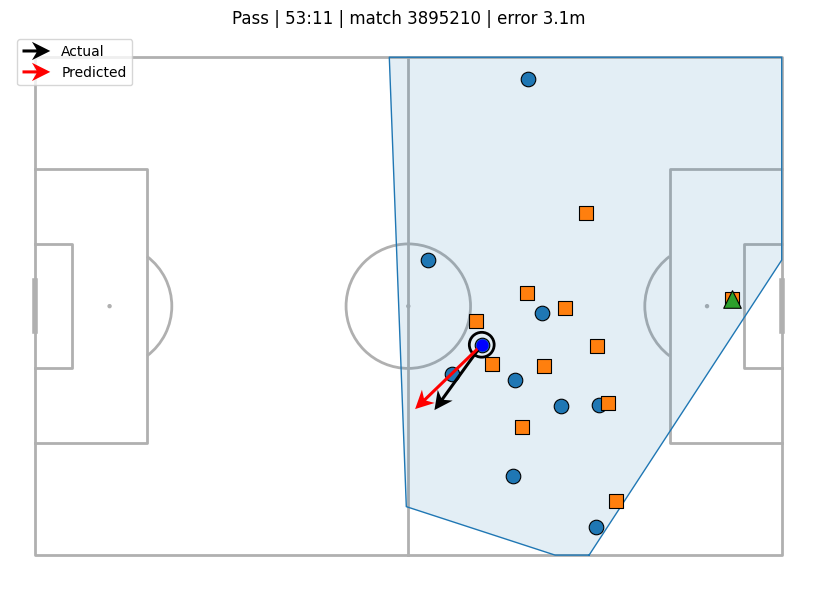

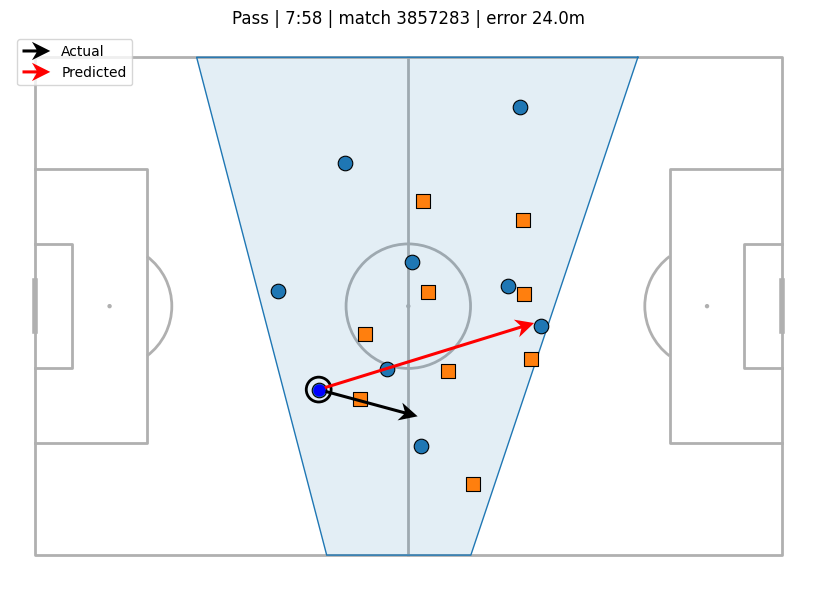

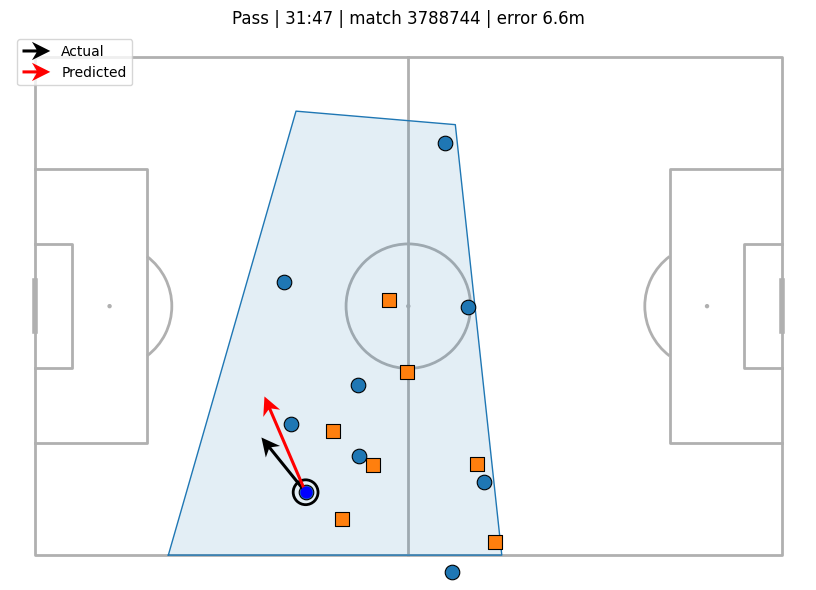

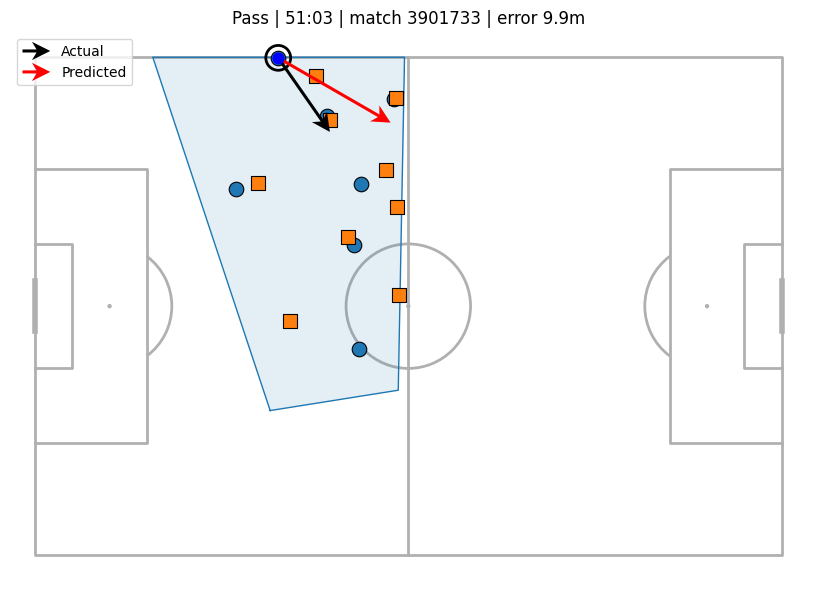

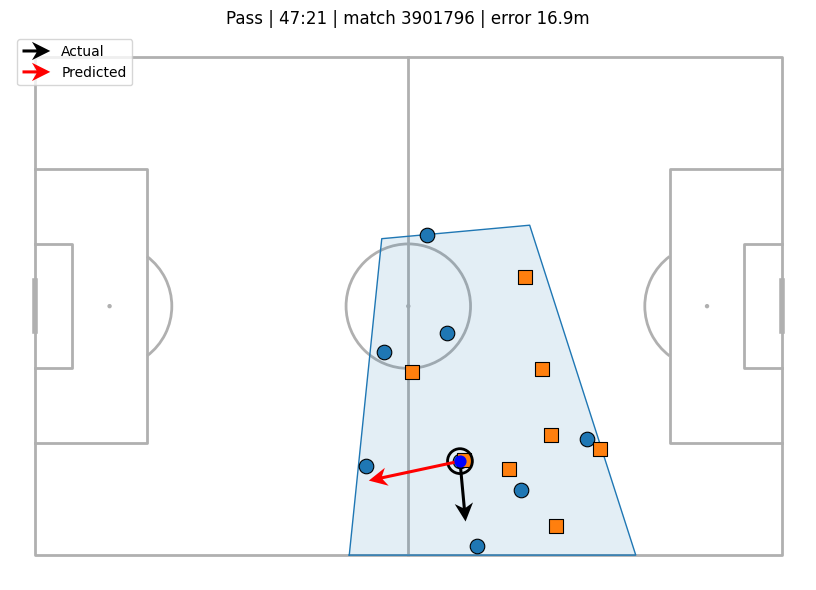

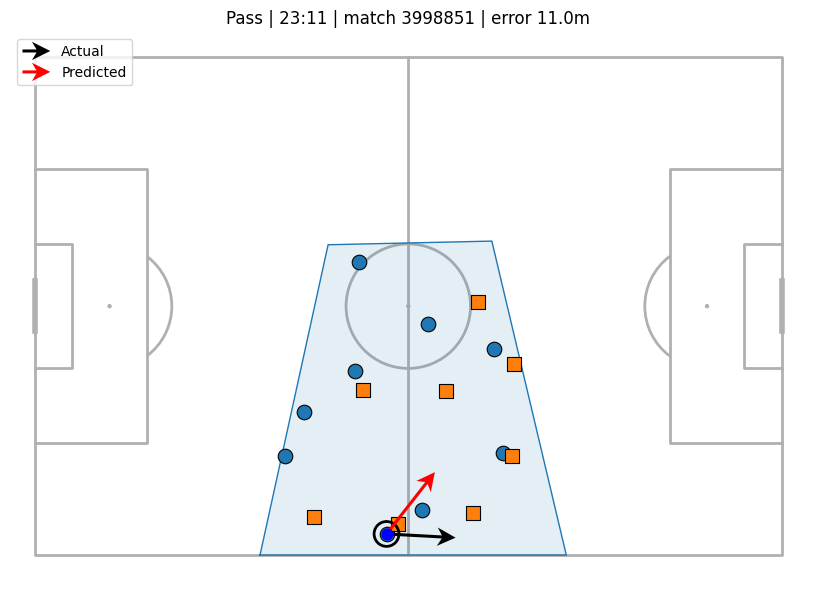

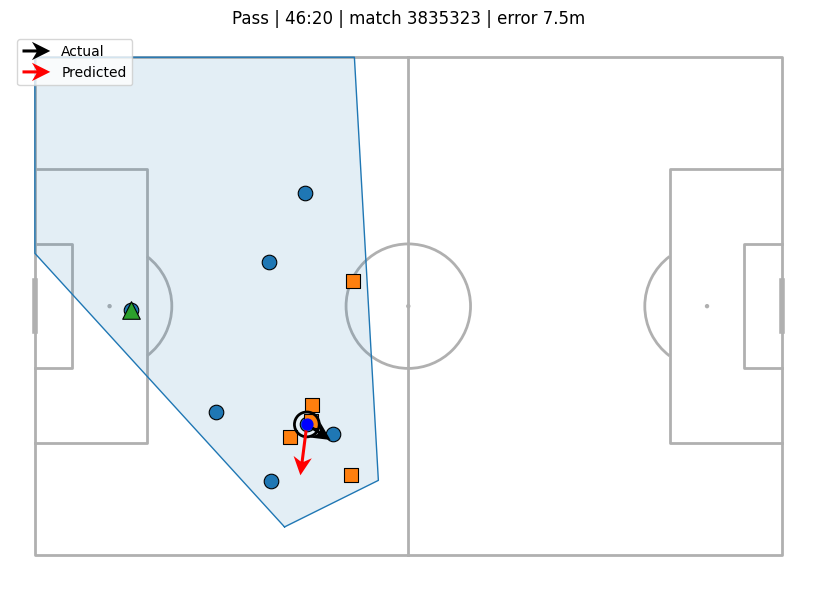

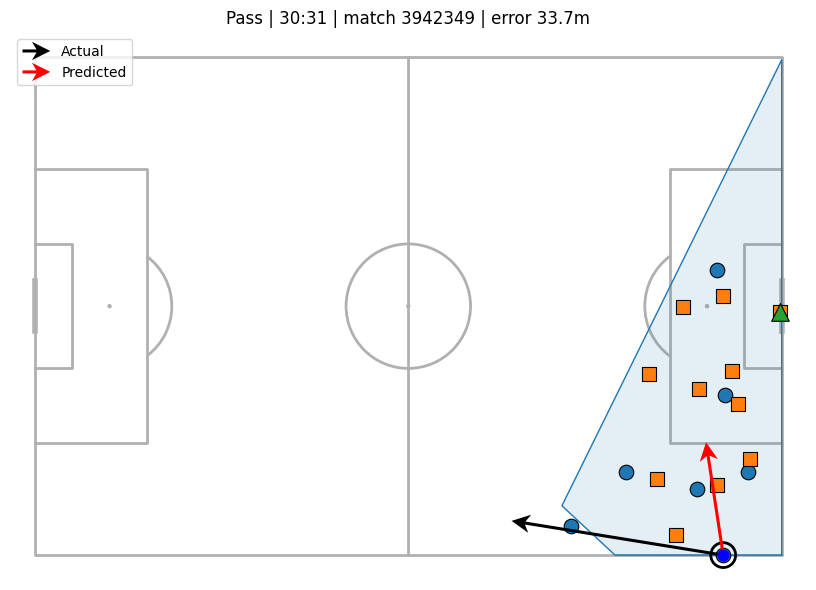

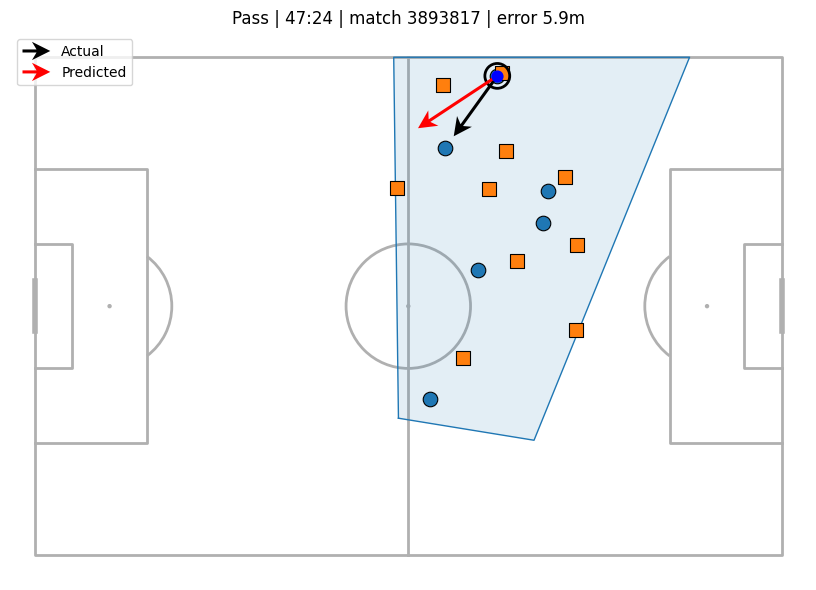

In [151]:
# test_vis must already include x_pred/y_pred and event_id/match_id
for _, row in test_vis.sample(9, random_state=47).iterrows():
    plot_pass_with_freeze_frame(sb_root, row)



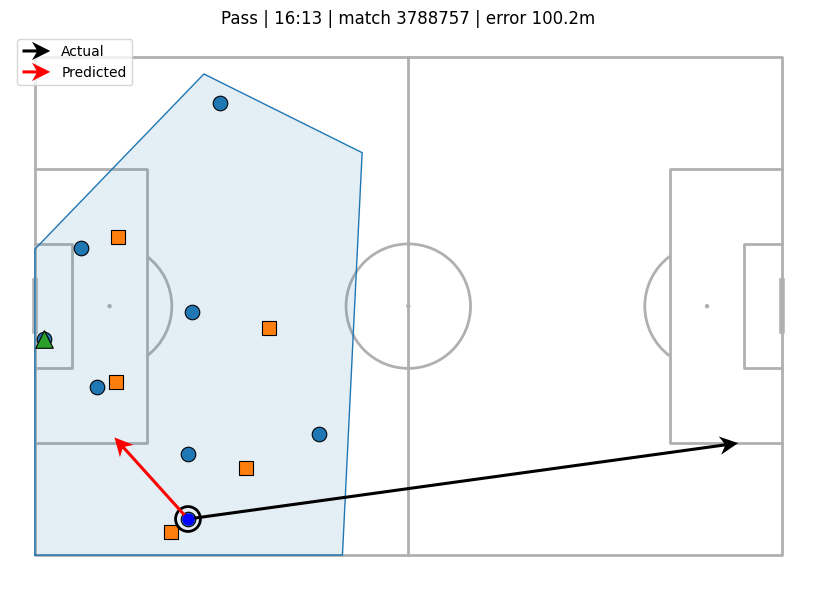

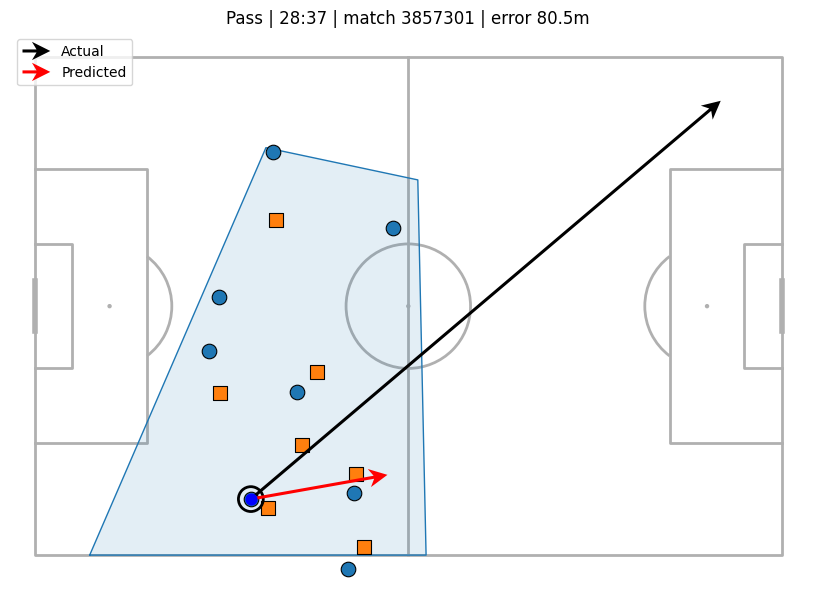

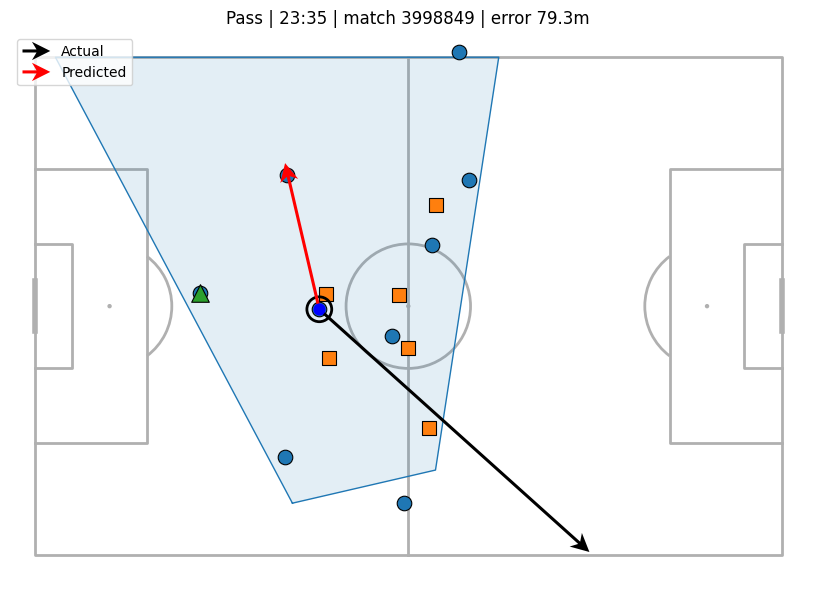

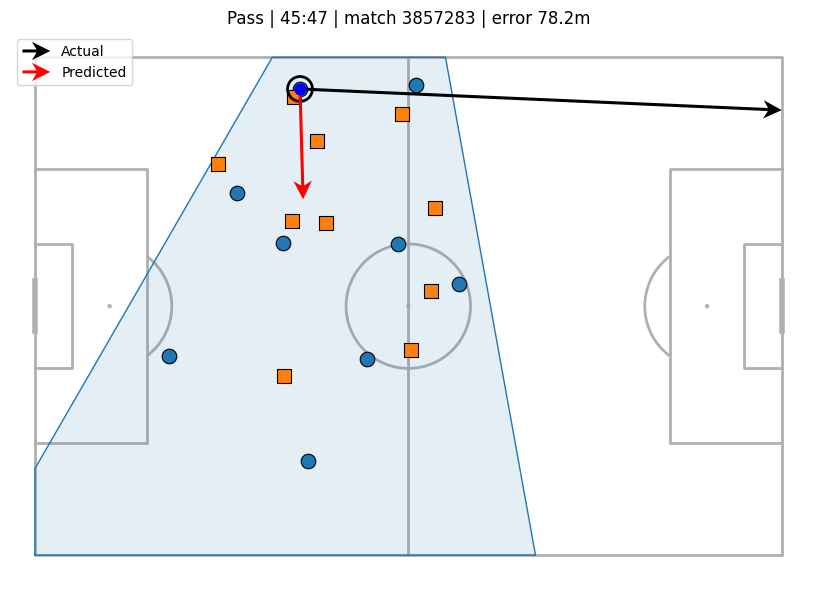

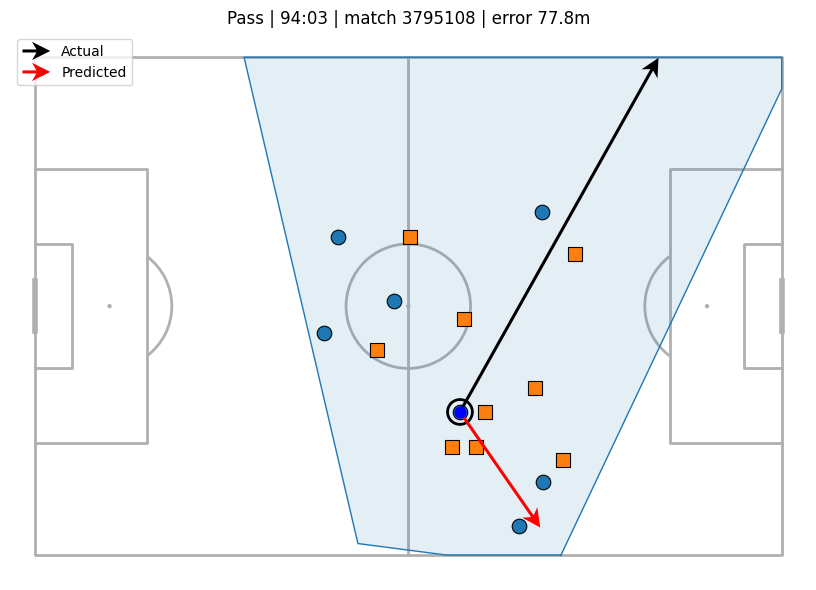

In [152]:
err = np.sqrt((test_vis["x_pred"]-test_vis["x_end"])**2 + (test_vis["y_pred"]-test_vis["y_end"])**2)
worst = test_vis.assign(err=err).sort_values("err", ascending=False).head(5)

for _, row in worst.iterrows():
    plot_pass_with_freeze_frame(sb_root, row)
